## Load raster data from a weather model

In [13]:
import pygrib

infile = '/home/data/hrrr.t18z.wrfsfcf18.grib2'
grb = pygrib.open(infile)
for g in grb:
    print(g)

# Let's get the wind speed and surface elevation
# 46:Orography:m (instant):lambert:surface:level 0:fcst time 18 hrs:from 201704051800
# 61:10 metre wind speed:m s**-1 (max):lambert:heightAboveGround:level 10 m:fcst time 17-18 hrs (max):from 201704051800
msg = grb.select(name='Orography')[0]
elev = msg.values
lats, lons = msg.latlons()  # get the coordinates of the grid
msg = grb.select(name='10 metre wind speed')[0]
WS = msg.values

1:Maximum/Composite radar reflectivity:dB (instant):lambert:unknown:level 0 10:fcst time 18 hrs:from 201704051800
2:3:3 (instant):lambert:cloudTop:level 0:fcst time 18 hrs:from 201704051800
3:Vertically-integrated liquid:kg m**-1 (instant):lambert:unknown:level 0 10:fcst time 18 hrs:from 201704051800
4:Visibility:m (instant):lambert:surface:level 0:fcst time 18 hrs:from 201704051800
5:Derived radar reflectivity:dB (instant):lambert:heightAboveGround:level 1000 m:fcst time 18 hrs:from 201704051800
6:Derived radar reflectivity:dB (instant):lambert:heightAboveGround:level 4000 m:fcst time 18 hrs:from 201704051800
7:Derived radar reflectivity:dB (instant):lambert:isothermal:level 263 K:fcst time 18 hrs:from 201704051800
8:Wind speed (gust):m s**-1 (instant):lambert:surface:level 0:fcst time 18 hrs:from 201704051800
9:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 25000 Pa:fcst time 18 hrs:from 201704051800
10:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:le

## Reproject raster data to a new grid

In [17]:
import pyproj
import numpy as np
from scipy.ndimage.interpolation import map_coordinates

P = pyproj.Proj(msg.projparams) # grb is the grib message object
'''
# These keywords are how you would specify a projection to PROJ4
{'a': 6371229,
 'b': 6371229,
 'lat_0': 38.5,
 'lat_1': 38.5,
 'lat_2': 38.5,
 'lon_0': 262.5,
 'proj': 'lcc'}
'''
# you can transform the lat, lon coordinates to Cartesian eastings, northings distances in meters
x, y = P(lons, lats)
# likewise the inverse transformation can convert easting, northing coordinates to lat, lon
# so we can back-calculate the origin
orig_lon, orig_lat = P(0, 0, inverse=True)
print('Origin latitudes %f, %f, longitude %f, %f' % (
      msg.projparams['lat_0'], orig_lat,
      msg.projparams['lon_0'] % 360, orig_lon % 360))  # normalize the longitude

# Let's reproject a 0.01 degree cylindrical equidistant map of New Hampshire
NH_bounds = (-72.56, 42.69, -70.70, 45.31)
gridspace = 0.01
nlon = np.round((NH_bounds[2] - NH_bounds[0]) / gridspace + 1).astype(int)
nlat = np.round((NH_bounds[3] - NH_bounds[1]) / gridspace + 1).astype(int)
lon1d = np.linspace(NH_bounds[0], NH_bounds[2], nlon)
lat1d = np.linspace(NH_bounds[1], NH_bounds[3], nlon)
# grid with [0,0] as southwest (lower-left) corner -- dimensions are [lat, lon]
lon2d, lat2d = np.meshgrid(lon1d, lat1d)
# reproject to the map coordinates
x2d, y2d = P(lon2d, lat2d)
# offset the coordinates based on lower-left corner and grid spacing
ll_x, ll_y = P(lons[0,0], lats[0,0])
dx = P(lons[0,1], lats[0,1])[0] - ll_x
dy = P(lons[1,0], lats[1,0])[1] - ll_y
print("Lower-left corner offset %f, %f and grid spacing %f, %f" % (ll_x, ll_y, dx, dy))
xind = (x2d - ll_x)/dx
yind = (y2d - ll_y)/dy
print("NH image index x-limits (%f, %f) y-limits (%f, %f)" %
      (xind.min(), xind.max(), yind.min(), yind.max()))
# reproject the grid using scipy's image coordinate mapping which defaults to 3rd order spline
# NB: the default cubic spline can result an unphysical (out of range) values
image_coords = np.array([yind, xind])
NH_elev = map_coordinates(elev, image_coords, order=1)

Origin latitudes 38.500000, 38.500000, longitude 262.500000, 262.500000
Lower-left corner offset -2697520.142522, -1587306.152557 and grid spacing 3000.000000, 3000.000000
NH image index x-limits (1546.092967, 1621.032453) y-limits (776.299923, 883.871753)


## Plot the original and reprojected grids

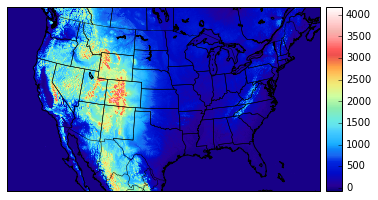

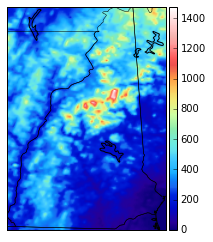

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm

m = Basemap(llcrnrlon=lons[0, 0], llcrnrlat=lats[0, 0], urcrnrlon=lons[-1, -1], urcrnrlat=lats[-1, -1],
                projection=msg.projparams['proj'], rsphere=(msg.projparams['a'], msg.projparams['b']),
                lat_0=msg.projparams['lat_0'], lat_1=msg.projparams['lat_1'], lat_2=msg.projparams['lat_2'],
                lon_0=msg.projparams['lon_0'],
                resolution='l')
im = m.imshow(elev, cm.GMT_haxby)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
cb = m.colorbar(im,"right", size="5%", pad='2%')
plt.show()
plt.clf()

m = Basemap(llcrnrlon=lon2d[0, 0], llcrnrlat=lat2d[0, 0], urcrnrlon=lon2d[-1, -1], urcrnrlat=lat2d[-1, -1],
            projection='cyl', resolution='h')
im = m.imshow(NH_elev, cm.GMT_haxby)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
cb = m.colorbar(im,"right", size="5%", pad='2%')
plt.show()
plt.clf()

## Convert a raster grid to contour polygons and save to a shapefile

In [24]:
import itertools
from shapely.geometry import Polygon

def fix_invalid_polygon(bad_poly):
    """
    Repair invalid polygon
    :param bad_poly: bad polygon
    :return: list of (hopefully) repaired polygons
    """
    try:
        fixed = bad_poly.buffer(0)
    except AttributeError:
        # the "bad_poly" is actually a list of geometries
        return list(itertools.chain(*[fix_invalid_polygon(p) for p in bad_poly]))

    # check to see if we succeeded
    if fixed.is_valid:
        print("Repair successful!")

        if bad_poly.geom_type == fixed.geom_type:
            # we preserved geometry type and are done
            return [fixed]
        else:
            # the bad polygon may have been broken up into multiple polygons -- try to grab them if they exist
            new_polys = getattr(fixed, 'geoms', [fixed])
            # return a single list of all the fixed polygons
            return list(itertools.chain(*(fix_invalid_polygon(new_polys) for new_geom in new_polys if not new_geom.is_empty)))
    else:
        # we failed, just regurgitate it. yuck.
        return [fixed]


def collection2poly(coll) :
    """
    Convert a matplotlib collection of geometries to polygon
    
    :param coll: a collection of geometries from matplotlib's contour routine
    :return a list of polygons
    """
    polygons = []
    for i, geom in enumerate(coll.get_paths()):
        geom.should_simplify = False
        multipolygon = geom.to_polygons()

        if len(multipolygon) > 0:
            outside_polygon = multipolygon[0]
            interior_polygons = multipolygon[1:]

            # a valid polygon must have at least three vertices
            if len(outside_polygon) >= 3:
                combined_poly = Polygon(outside_polygon, interior_polygons)
                if combined_poly.is_valid:
                    polygons.append(combined_poly)
                else:
                    polygons.extend(fix_invalid_polygon(combined_poly))
    return polygons


def contour_raster(grid, lat, lon, lvls):
    """
    Contour raster data with given coordinate
    :param grid: raster grid
    :param lat: latitude array
    :param lon: longitude array
    :param lvls: contour levels
    :return: contour collection
    """
    fig, ax = plt.subplots()
    collection = ax.contourf(lon, lat, grid, lvls, extend='max').collections
    all_contours = [collection2poly(coll) for coll in collection]
    return all_contours

Saving contours to shapefile


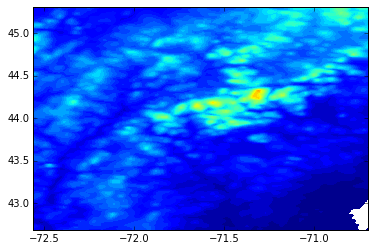

In [28]:
import geopandas as gpd
import os

# contour levels for elevation (m)
lvls = np.arange(0,41)*50  # 0 to 2000 m in 50 m intervals
contours = contour_raster(NH_elev, lat1d, lon1d, lvls)

print("Saving contours to shapefile")
elev_list, poly_list = [], []
for z, mp in zip(lvls, contours):
    for poly in itertools.chain(*[mp]):
        elev_list.append(z)
        poly_list.append(poly)
        
# create a GeoDataFrame and save results to shapefile
df = gpd.GeoDataFrame({'height': elev_list,
                       'geometry': poly_list
                       })
df.to_file('contours.shp')

In [29]:
%ls 

contours.cpg  contours.dbf  contours.shp  contours.shx  raster2shape.ipynb
